In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [4]:
def motion_model(x, u, dt):
    theta = x[2]
    dx = u[0] * np.cos(theta) * dt
    dy = u[0] * np.sin(theta) * dt
    dtheta = u[1] * dt
    return np.array([dx, dy, dtheta])

def ekf_slam(mu, sigma, u, z, landmarks, dt, Q, R):
    n_landmarks = len(landmarks)
    n = 3 + 2 * n_landmarks

    x, y, theta = mu[0], mu[1], mu[2]
    delta = motion_model(mu[:3], u, dt)
    mu[:3] += delta

    G = np.eye(n)
    G[0, 2] = -u[0] * np.sin(theta) * dt
    G[1, 2] = u[0] * np.cos(theta) * dt

    Fx = np.hstack((np.eye(3), np.zeros((3, 2 * n_landmarks))))
    sigma = G @ sigma @ G.T + Fx.T @ Q @ Fx

    for i, lm_id in enumerate(z['ids']):
        lm_index = 3 + 2 * lm_id
        dx = mu[lm_index] - mu[0]
        dy = mu[lm_index+1] - mu[1]
        q = dx**2 + dy**2

        z_pred = np.array([
            np.sqrt(q),
            np.arctan2(dy, dx) - mu[2]
        ])
        z_meas = np.array(z['data'][i])

        H = np.zeros((2, n))
        sqrt_q = np.sqrt(q)
        H[0, 0] = -dx / sqrt_q
        H[0, 1] = -dy / sqrt_q
        H[0, lm_index] = dx / sqrt_q
        H[0, lm_index+1] = dy / sqrt_q

        H[1, 0] = dy / q
        H[1, 1] = -dx / q
        H[1, 2] = -1
        H[1, lm_index] = -dy / q
        H[1, lm_index+1] = dx / q

        S = H @ sigma @ H.T + R
        K = sigma @ H.T @ np.linalg.inv(S)
        y_k = z_meas - z_pred
        y_k[1] = (y_k[1] + np.pi) % (2*np.pi) - np.pi  # açı düzeltme

        mu += K @ y_k
        sigma = (np.eye(n) - K @ H) @ sigma

    return mu, sigma

In [7]:
dt = 0.1
landmarks = np.array([[5, 10], [10, 5]])
n_landmarks = len(landmarks)
mu = np.zeros(3 + 2 * n_landmarks)
mu[3:] = landmarks.flatten() + np.random.randn(4) * 0.5
sigma = np.eye(len(mu)) * 0.5

Q = np.diag([0.1, 0.1, np.deg2rad(1)])**2
R = np.diag([0.5, np.deg2rad(10)])**2
history = []
for step in range(50):
    u = [1.0, 0.1]
    z = {'data': [], 'ids': []}
    for i, lm in enumerate(landmarks):
        dx = lm[0] - mu[0]
        dy = lm[1] - mu[1]
        distance = np.sqrt(dx**2 + dy**2) + np.random.randn() * 0.1
        angle = np.arctan2(dy, dx) - mu[2] + np.random.randn() * 0.05
        z['data'].append([distance, angle])
        z['ids'].append(i)

    mu, sigma = ekf_slam(mu, sigma, u, z, landmarks, dt, Q, R)
    history.append(mu[:2].copy())

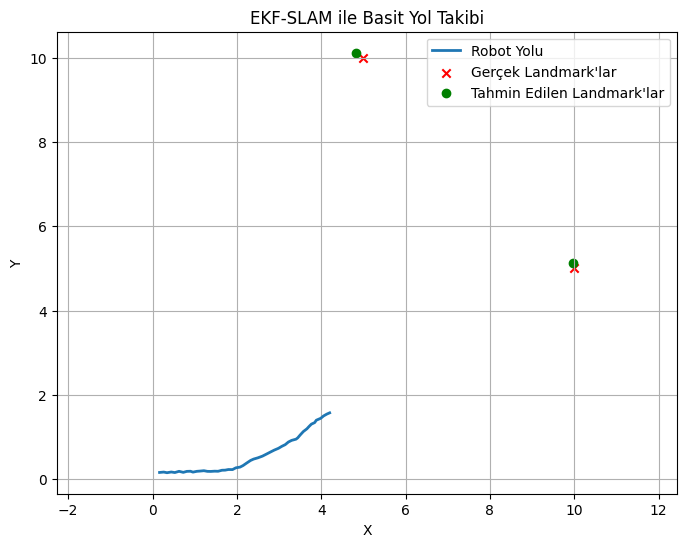

In [10]:
history = np.array(history)
plt.figure(figsize=(8, 6))
plt.plot(history[:, 0], history[:, 1], label="Robot Yolu", linewidth=2)
plt.scatter(landmarks[:, 0], landmarks[:, 1], c='red', label="Gerçek Landmark'lar", marker='x')
plt.scatter(mu[3::2], mu[4::2], c='green', label="Tahmin Edilen Landmark'lar", marker='o')
plt.legend()
plt.title("EKF-SLAM ile Basit Yol Takibi")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.grid()
plt.show()